<h1>Tram signal classification</h1>

In [1]:
#SET UP
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
set_session(sess)

Using TensorFlow backend.


In [1]:
#imports
import pickle
import os
import numpy as np
from tqdm import tqdm
from python_speech_features import mfcc
from keras.models import load_model
import pandas as pd
import librosa

Using TensorFlow backend.


In [3]:
class Config:
    def __init__(self, mode='conv', nfilt=60, nfeat=13, nfft=1024, rate=16000):
        self.mode = mode
        self.nfilt = nfilt
        self.nfeat = nfeat
        self.rate = rate
        self.nfft = nfft
        self.step = int(rate/2)
        self.model_path = os.path.join('models', mode + '.model')
        self.p_path = os.path.join('pickles', mode + '.p')


config = Config(mode='conv')
config.max = 68.85964767524779
config.min = -83.47210746139987

<h2>INSERT FILE PATH</H2>

In [13]:
file = 'tram_demo/test_files/tram-2018-11-30-15-30-17.wav'

In [14]:
#defs

def build_predictions(file):
    y_true = []
    y_pred = []
    fn_prob = {} #for softmax probs
    y_prob = []
    
    wav, rate = librosa.load(file, sr=16000)
    
    for i in tqdm(range(0, wav.shape[0]-config.step, 10)): #'x10' for fewer samplepoints 
        sample = wav[i:i+config.step]
        x = mfcc(sample, rate, numcep=config.nfeat,
                 nfilt=config.nfilt, nfft=config.nfft)
        
        #normalization
        x = (x - config.min)/(config.max - config.min)
        #reshaping for CNN purposes + grayscale layer
        x = x.reshape(1, x.shape[0], x.shape[1], 1)
        
        y_hat = model.predict(x)
        y_prob.append(y_hat)
        y_pred.append(np.argmax(y_hat)) #for the max val in y_hat, taking the index
        #y_true.apppend(c)
        fn_prob[i] = np.mean(y_prob, axis=0).flatten()
    #fn_prob[fn] = np.mean(y_prob, axis=0).flatten()
    return y_true, y_pred, fn_prob

In [ ]:
# p_path = os.path.join('pickles', 'conv.p')
# with open(p_path, 'rb') as handle:
#     config = pickle.load(handle)
#file = 'tram_demo/test_files/tram-2018-12-07-15-32-08.wav'

classes = ['accelerating_1_New', 'accelerating_2_CKD_Long', 'accelerating_3_CKD_Short', 'accelerating_4_Old', 
           'braking_1_New', 'braking_2_CKD_Long', 'braking_3_CKD_Short', 'braking_4_Old', 'negative']

    
model = load_model('models/conv.model')
path_ = 'tram_demo/test_files'



y_true, y_pred, fn_prob = build_predictions(file)
#acc_score = accuracy_score(y_true=y_true, y_pred=y_pred)

df = pd.DataFrame.from_dict(fn_prob, orient='index')

df = pd.read_csv('df_structure.csv')
seconds_offset = []
for key in fn_prob:
    seconds_offset.append(key)
df["seconds_offset"] = seconds_offset
df.set_index('seconds_offset', inplace=True)
y_probs = []
for key in fn_prob:
    y_prob = fn_prob[key]
    y_probs.append(y_prob)
    for c, p in zip(classes, y_prob):
       df.at[key, c] = p


y_pred = [classes[np.argmax(y)] for y in y_probs]
df['y_pred'] = y_pred
df['index'] = range(0, len(df))
df.set_index('index', inplace=True)
df["seconds_offset"] = seconds_offset
df.to_csv('predictions_.csv', index=False)
print('CSV succesfuly written!')

 90%|█████████ | 432488/479200 [9:03:13<1:49:08,  7.13it/s]

In [39]:

df.tail()


,accelerating_1_New,accelerating_2_CKD_Long,accelerating_3_CKD_Short,accelerating_4_Old,braking_1_New,braking_2_CKD_Long,braking_3_CKD_Short,braking_4_Old,negative,y_pred,seconds_offset
index,,,,,,,,,,,
47979,0.00612004,0.00037264,0.00209162,0.0141423,0.0478943,0.0122613,0.0242149,0.05414,0.838771,negative,4797900
47980,0.00611993,0.000372632,0.00209158,0.014142,0.0479023,0.012261,0.0242145,0.0541403,0.838763,negative,4798000
47981,0.00611989,0.000372624,0.00209154,0.0141418,0.0479131,0.0122608,0.024214,0.0541396,0.838754,negative,4798100
47982,0.00611981,0.000372617,0.00209149,0.0141415,0.0479289,0.0122606,0.0242135,0.054139,0.83874,negative,4798200
47983,0.00611971,0.000372609,0.00209145,0.0141412,0.0479454,0.0122604,0.024213,0.0541382,0.838726,negative,4798300


<h1><b>PLOTTING</b></h1>

In [7]:

df = pd.read_csv('predictions_.csv')


df.head()



,accelerating_1_New,accelerating_2_CKD_Long,accelerating_3_CKD_Short,accelerating_4_Old,braking_1_New,braking_2_CKD_Long,braking_3_CKD_Short,braking_4_Old,negative,y_pred,seconds_offset
0,2.291528e-09,2.022402e-07,7.885011e-16,6.444020e-07,0.000003,2.746647e-09,1.600789e-08,2.898583e-08,0.999996,negative,0
1,2.081013e-09,2.079482e-07,6.430369e-16,5.414821e-07,0.000003,2.328083e-09,1.551231e-08,2.609393e-08,0.999996,negative,100
2,3.080317e-09,3.253387e-07,1.181367e-15,5.889498e-07,0.000006,2.998657e-09,2.433799e-08,3.750361e-08,0.999993,negative,200
3,3.543040e-09,3.660110e-07,1.486299e-15,6.414942e-07,0.000006,3.426640e-09,2.776781e-08,4.249527e-08,0.999993,negative,300
4,3.126193e-09,3.265078e-07,1.257180e-15,5.914377e-07,0.000006,3.051922e-09,2.454297e-08,3.765621e-08,0.999993,negative,400


<h1>PLOTS</h1>

In [9]:
df.columns
df.set_index('seconds_offset', inplace=True)
df.groupby("y_pred").mean()

KeyError: 'seconds_offset'

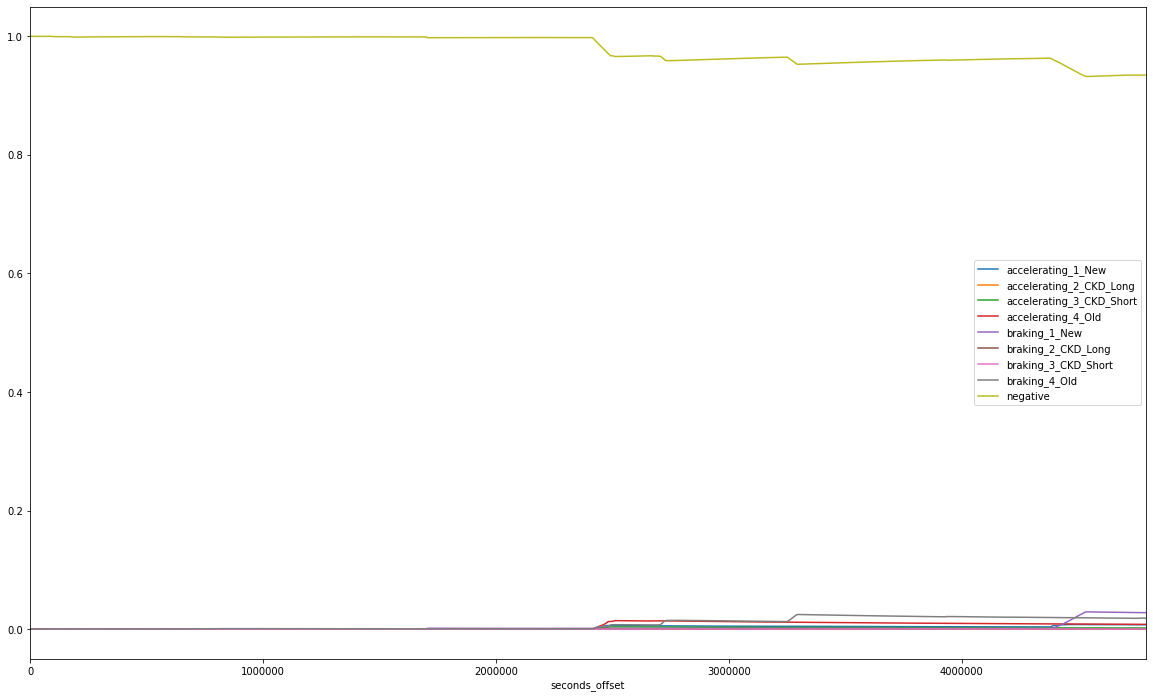

In [11]:
df.plot(figsize=(20,12))
